In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/newdata/sample_submission.csv
/kaggle/input/newdata/data_description.txt
/kaggle/input/newdata/train.csv
/kaggle/input/newdata/test.csv


clean up

In [14]:

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv('/kaggle/input/newdata/train.csv')


df.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True, errors='ignore')


In [15]:

df['street_num'] = np.where(df['Street'] == 'Pave', 1, 0)
df['central_air_num'] = np.where(df['CentralAir'] == 'Y', 1, 0)
df.drop(columns=['Street', 'CentralAir'], inplace=True)

df.fillna(df.median(numeric_only=True), inplace=True)

train/test split

In [16]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X.select_dtypes(include=[np.number]), y, test_size=0.2, random_state=42)




In [17]:
from sklearn.compose import ColumnTransformer

scalers = [
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler()),
    ('none', 'passthrough')
]

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # will be overwritten in grid search
    ('regressor', DecisionTreeRegressor(random_state=42))
])



In [18]:
param_grid = {
    'scaler': [s[1] for s in scalers],
    'regressor__max_depth': [5, 10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error',
    verbose=2,
    return_train_score=True
)

Evaluation part

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=MinMaxScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=MinMaxScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=MinMaxScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=

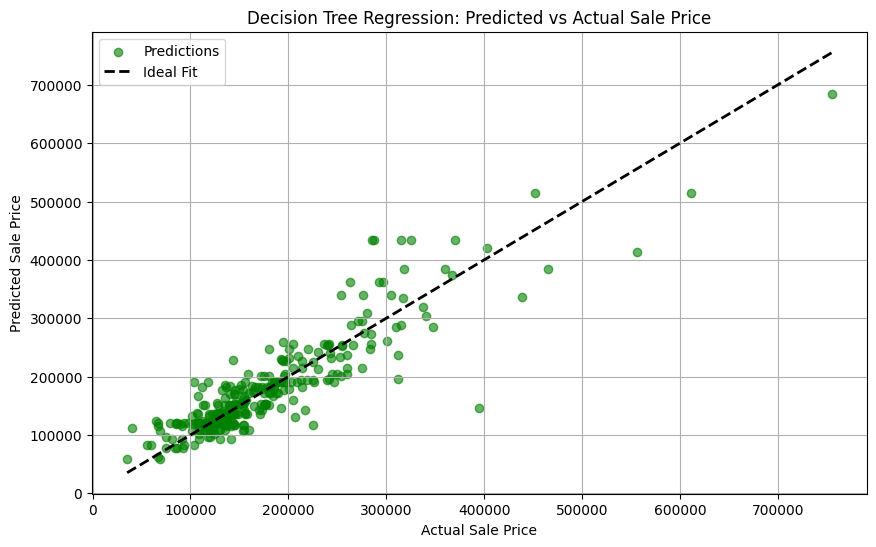

In [19]:

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R^2: {r2:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Decision Tree Regression: Predicted vs Actual Sale Price")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
!pip install dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: graphql-core
    Found existing installation: graphql-core 3.2.6
    Uninstalling graphql-core-3.2.6:
      Successfully uninstalled graphql-core-3.2.6
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.12.2 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.


დაგსჰაბთან დაკავშირება

In [21]:
import dagshub
dagshub.init(repo_owner='nurch22', repo_name='my-first-repo', mlflow=True)


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=07600e01-cc02-4dc1-b1d6-21fe6fb1edb1&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=557edf9ad819230877d6acbc0dc0ee0d87ac1642c5e4c39c9129195067a78ba1




Output()

Accessing as nurch22

Initialized MLflow to track repo "nurch22/my-first-repo"

Repository nurch22/my-first-repo initialized!

In [22]:
!pip install mlflow

In [23]:
import mlflow
import mlflow.sklearn


mlflo-wზე ატვირთვის ნაწილი

In [24]:
from mlflow.models.signature import infer_signature

with mlflow.start_run():

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nBest Parameters: {grid_search.best_params_}")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test MAE: {mae:.2f}")
    print(f"Test R^2: {r2:.4f}")

    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Example input and signature
    input_example = X_test.iloc[:1]
    signature = infer_signature(X_test, y_pred)

    mlflow.sklearn.log_model(
        best_model,
        "decision_tree_model",
        signature=signature,
        input_example=input_example
    )


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=MinMaxScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=MinMaxScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=MinMaxScaler(); total time=   0.0s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, scaler=

/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run bold-squirrel-972 at: https://dagshub.com/nurch22/my-first-repo.mlflow/#/experiments/0/runs/25b2d27936ad49dc82b1412a99406762
🧪 View experiment at: https://dagshub.com/nurch22/my-first-repo.mlflow/#/experiments/0
